In [1]:
### Created by Ian Nesbitt, University of Maine, using RaspberryShake UDP documentation:
### https://manual.raspberryshake.org/udp.html

### Live updating plot created using the following as a template:
### https://github.com/anujgupta82/Musings/blob/master/Dynamic%20or%20Live%20update%20of%20a%20Plot.ipynb

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# NOTE: I don't know why, but you have to run the import cells twice in order for this to work.
# If someone can figure out why, or find a less dirty workaround, please let me know.
# ian dot nesbitt at gmail dot com

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Waiting for data on Port: 18002


<IPython.core.display.Javascript object>


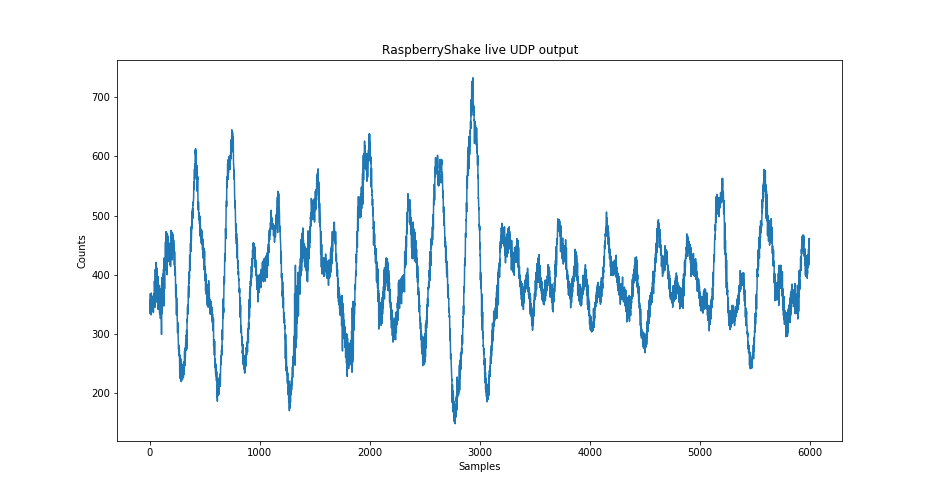

KeyboardInterrupt: 

In [4]:
import socket as s
import matplotlib.pyplot as plt

ch = 'EHZ'                               # pick your favorite channel
host = ''                                # blank for localhost (data is being sent here by remote Shake!)
port = 18002                             # Port to bind to
sock = s.socket(s.AF_INET, s.SOCK_DGRAM | s.SO_REUSEADDR)
sock.bind((host, port))
print('Waiting for data on Port:', port)


#initialize the graph and settings
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

stream = []                             # our stream (simple list object)

while 1:                                # loop forever
    data, addr = sock.recvfrom(1024)    # wait to receive data
    s = data.decode('UTF-8').strip("'{} ").split(', ') # clean and listify the data
    if ch in s[0]:                      # only listen to the specific channel
        ax.clear()                      # ready the axis for a new draw
        ax.set(title='RaspberryShake live UDP output', xlabel='Samples', ylabel='Counts')
        for smp in s[2:]:               # convert strings
            stream.append(int(smp))
        if len(stream) > 6000:          # 6000 samples per minute
            stream = stream[-6000:]     # move the array to the right, get rid of old samples
        ax.plot(stream)
        fig.canvas.draw()